## Serving Three Models to a Single Endpoint using MLflow.

### Define a Custom Model class with 3 different models

#### NOTE: It is not common to pass a single number as input to mlflow model. This is just for intuition of serving a model. 

In [ ]:
import mlflow
from mlflow_utils import create_mlflow_experiment
from mlflow.models.signature import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.types import ColSpec
from mlflow.types import Schema
from mlflow.types import ParamSpec
from mlflow.types import ParamSchema

import numpy as np


class CustomModel(mlflow.pyfunc.PythonModel):
    def predict_model1(self, model_input):
        # do some processing for model 1
        return 0 * model_input

    def predict_model2(self, model_input):
        # do some processing for model 2
        return model_input

    def predict_model3(self, model_input):
        # do some processing for model 3
        return 2 * model_input

    def predict(self, context, model_input: Dict[str, Any], params: Dict[str, str]) -> List[int]:
        if params["model_name"] == "model_1":
            return self.predict_model1(model_input=model_input)

        elif params["model_name"] == "model_2":
            return self.predict_model2(model_input=model_input)

        elif params["model_name"] == "model_3":
            return self.predict_model3(model_input=model_input)

        else:
            raise Exception("Model Not Found!")

c:\Users\dof07\anaconda3\envs\mlflow\lib\site-packages\mlflow\types\type_hints.py:221: UserWarning: Any type hint is inferred as AnyType, and MLflow doesn't validate the data for this type. Please use a more specific type hint to enable data validation.
  dtype=Map(_infer_colspec_type_from_type_hint(type_hint=args[1]).dtype),


### Create a new MLflow experiment

In [4]:
experiment_id = create_mlflow_experiment(
    experiment_name="Serving Multiple Models",
    artifact_location="serving_multiple_models",
    tags={"purpose": "learning"},
)
print(experiment_id)

756996283489239478


### Define the model signature with input, output, and parametre schema

In [ ]:
from mlflow.types import ColSpec, Schema, ParamSchema, ParamSpec
from mlflow.models.signature import ModelSignature

# Define Input & Output Schemas
input_schema = Schema(inputs=[ColSpec(type="integer", name="input")])  
output_schema = Schema(inputs=[ColSpec(type="integer", name="output")]) 

# Define Parameter Schema
param_spec = ParamSpec(name="model_name", dtype="string", default=None)
param_schema = ParamSchema(params=[param_spec])

# Define Model Signature
model_signature = ModelSignature(
    inputs=input_schema, 
    outputs=output_schema, 
    params=param_schema
)

# Print the Model Signature
print(model_signature)

inputs: 
  ['input': integer (required)]
outputs: 
  ['output': integer (required)]
params: 
  ['model_name': string (default: None)]



In [ ]:
input_schema = Schema(inputs=[ColSpec(type="integer", name="input")])
output_schema = Schema(inputs=[ColSpec(type="integer", name="output")])
param_spec = ParamSpec(name="model_name", dtype="string", default=None)
param_schema = ParamSchema(params=[param_spec])
model_signature = ModelSignature(
    inputs=input_schema, outputs=output_schema, params=param_schema
)
print(model_signature)

inputs: 
  ['data': integer (required)]
outputs: 
  ['output': integer (required)]
params: 
  ['model_name': string (default: None)]



### Run MLflow

- `mlflow.pyfunc` as you are using a custom model

In [51]:
with mlflow.start_run(run_name="multiple_models", experiment_id=experiment_id) as run:

    mlflow.pyfunc.log_model(artifact_path="model", python_model=CustomModel(), signature=model_signature)

    model_uri = f"runs:/{run.info.run_id}/model"
    loaded_model = mlflow.pyfunc.load_model(model_uri=model_uri)

    for n in range(3):
        print(f"PREDICTION FROM MODEL {n+1}")
        print(loaded_model.predict(data={"input":np.int32(10)}, params={"model_name":f"model_{n+1}"}))
        print("\n")

    print(f"RUN_ID: {run.info.run_id}")

2025/03/04 15:12:10 INFO mlflow.models.signature: Inferring model signature from type hints
c:\Users\dof07\anaconda3\envs\mlflow\lib\site-packages\mlflow\pyfunc\__init__.py:3139: UserWarning: Failed to infer signature from type hint: Type hints must be wrapped in list[...] because MLflow assumes the predict method to take multiple input instances. Specify your type hint as `list[typing.Dict[str, typing.Any]]` for a valid signature.
  signature_from_type_hints = _infer_signature_from_type_hints(
c:\Users\dof07\anaconda3\envs\mlflow\lib\site-packages\mlflow\pyfunc\__init__.py:3212: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


PREDICTION FROM MODEL 1
   input
0      0


PREDICTION FROM MODEL 2
   input
0     10


PREDICTION FROM MODEL 3
   input
0     20


RUN_ID: beee8233bb604e8c82c54c99e6960c85


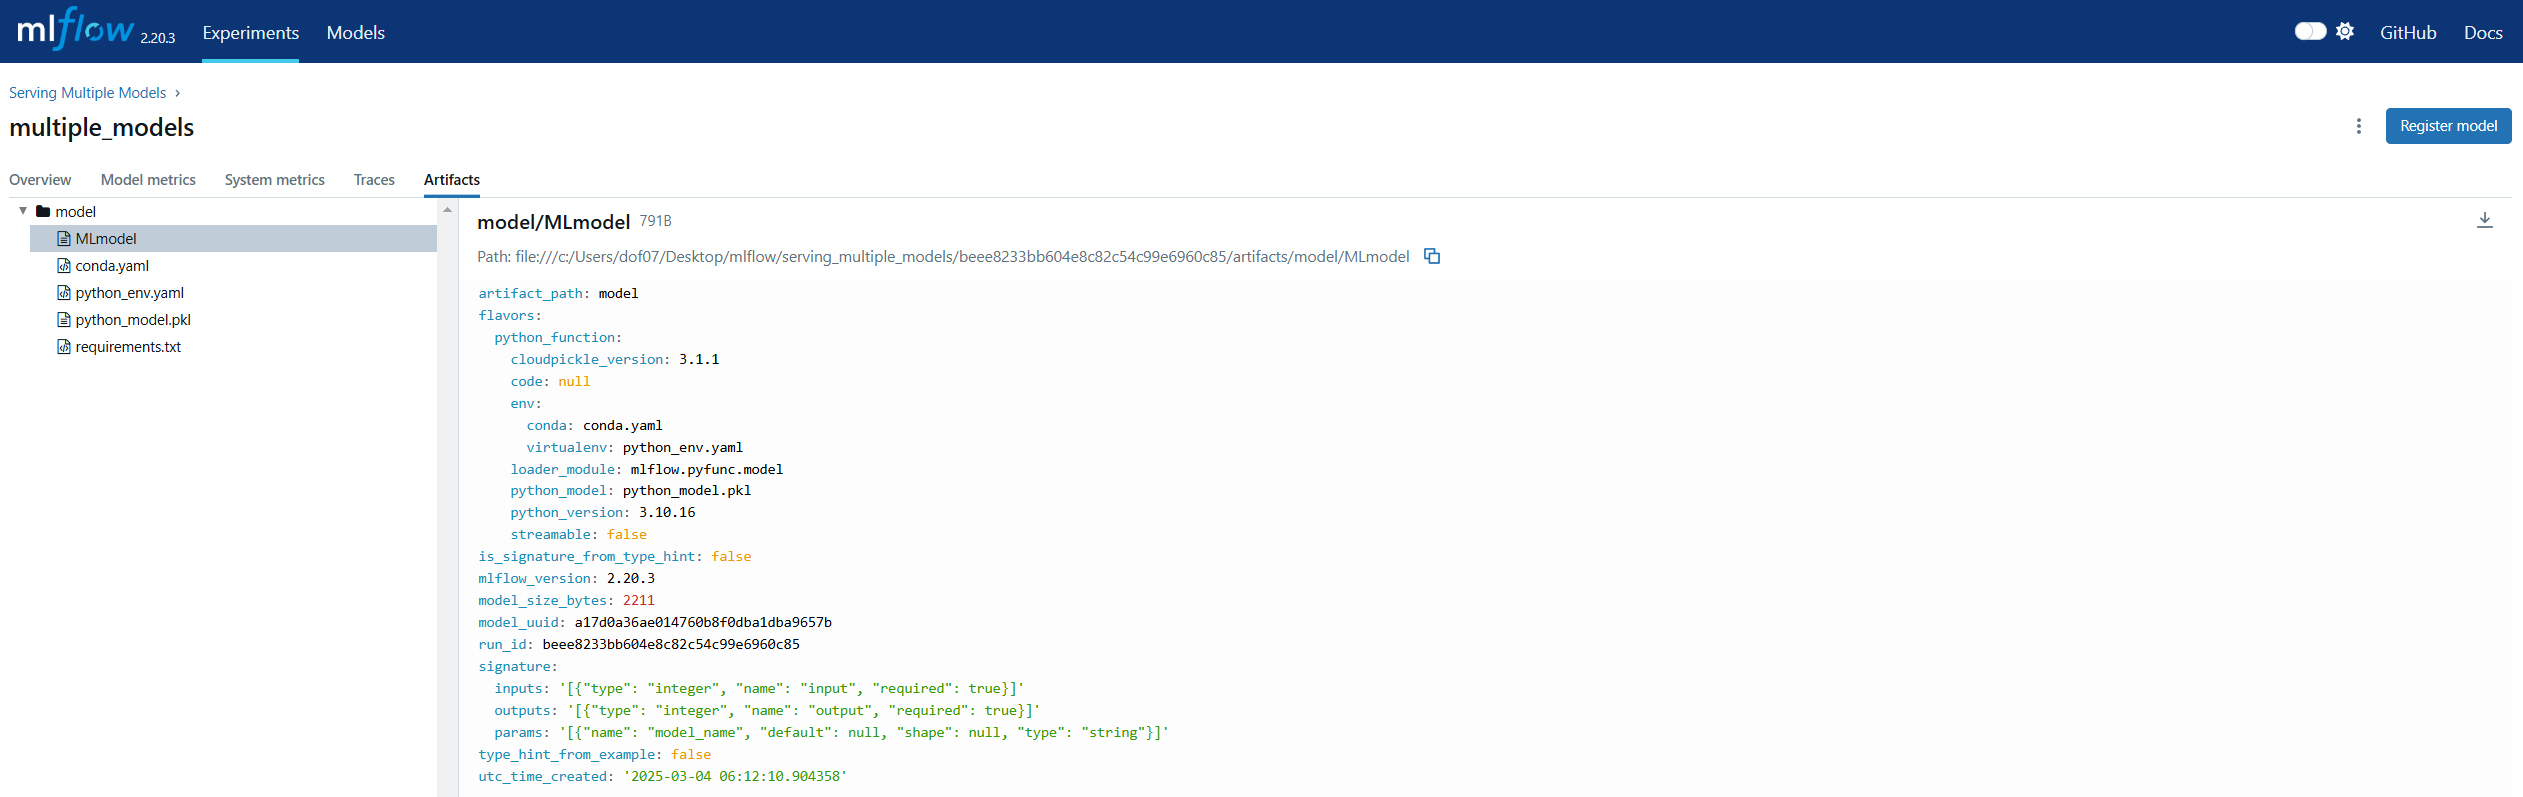

In [ ]:
""" serve the model on a local machine """
# cli: mlflow models serve --model-uri runs:/beee8233bb604e8c82c54c99e6960c85/model

## Making Online Inference

- model_3 doubles the input and return as prediction

In [56]:
import json
import requests

data = {
    "dataframe_split": {"columns": ["input"], "data": [15]},
    "params": {"model_name": "model_3"},
}

headers = {"Content-Type": "application/json"}
endpoint = "http://127.0.0.1:5001/invocations"

r = requests.post(endpoint, data=json.dumps(data), headers=headers)
print(r.status_code)
print(r.text)

200
{"predictions": [{"input": 30}]}
